##### The latest version of this Jupyter notebook is available at [http://github.com/jckantor/CBE40455](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Binomial Model for Pricing Options

This notebooks demonstrates techniques for pricing options using a binomial lattice to model prices of the underlying security or commodity. The notebook makes use of the pandas_datareader library to download pricing information, and the Pyomo modeling library for some example calculations.

    !pip install pandas_datareader

## Historical Data

The first step is download historical data for a selected security or commodity.  For the purposes of this notebook, it is useful to choose security of commodities for which there is an active options trading so the pricing model can be compared to real data.

##### Programming note
Given a stock market symbol, the function ``yahoo_finance`` defined in the following cell creates a pandas data series object ``S`` of historical prices.

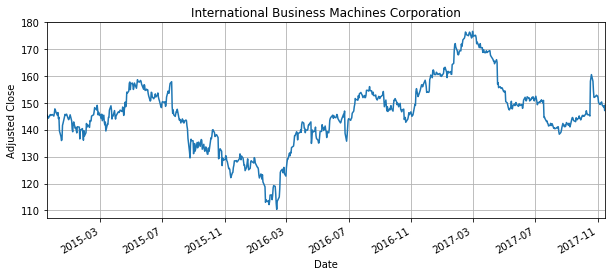

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import datetime
from pandas_datareader import data, wb

import requests

def yahoo_finance(symbol, nYears = 3):
    
    def get_description(symbol):
        """
        get_symbol(symbol) uses Yahoo to look up a stock trading symbol and 
        return a description.
        """
        url = 'http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en'
        result = requests.get(url.format(symbol)).json()
        for x in result['ResultSet']['Result']:
            if x['symbol'] == symbol:
                return x['name']

    # end date is today
    end = datetime.datetime.today().date()
    start = end - datetime.timedelta(nYears*365)

    # get stock price data. Give it three trys
    for nTry in range(0,3):
        try:
            S = data.DataReader(symbol,"yahoo",start,end)['Adj Close']
            description = get_description(symbol)
            break
        except:
            pass
    S.name = symbol
    
    # plot data
    plt.figure(figsize=(10,4))
    S.plot(title=description)
    plt.ylabel('Adjusted Close')
    plt.grid()
    
    return S

S = yahoo_finance('IBM')

# Fitting Historical Data to Geometric Brownian Motion

A model for Geometric Brownian Motion can be written in discrete time as

$$S_{t + \Delta t} = S_t + \mu S_t \Delta t + \sigma S_t \sqrt{\Delta t} Z_t $$

where $Z_t$ is a normal random variate with zero mean and a standard deviation of one. This could also be written as 

$$ \ln S_{t + \Delta t} = \ln S_t + \nu \Delta t + \sigma \sqrt{\Delta t} Z_t $$

where $\nu = \mu -\frac{\sigma^2}{2}$. These are two different models for price. The difference between $\mu$ and $\nu$, i.e.  $\frac{\sigma^2}{2}$, is referred to as 'volatility drag.' 

Rearranging each of these models

\begin{align*}
r^{lin} & = \frac{S_{t+\Delta t} - S_t}{S_t} = \mu\Delta t + \sigma \sqrt{\Delta t}Z_t \sim \cal{N}(\mu\Delta t, \sigma^2\Delta t)\\
r^{log} & = \ln S_{t+\Delta t} - \ln S_t = \nu\Delta t + \sigma \sqrt{\Delta t}Z_t \sim \cal{N}(\nu\Delta t,\sigma^2\Delta t)\\
\end{align*}

where $\cal{N}(\alpha,\beta)$ denotes the normal distribution with mean $\alpha$ and variance $\beta$ (i.e., standard deviation $\sqrt{\beta}$).

The parameters can be estimated from trading data as

\begin{align*}
\hat{\mu} & = \frac{1}{\Delta t} \mbox{mean}(\frac{S_{t+\Delta t} - S_t}{S_t}) \\
\hat{\nu} & = \frac{1}{\Delta t} \mbox{mean}(\ln S_{t+\Delta t} - \ln S_t) \\
\hat{\sigma} & = \frac{1}{\sqrt{\Delta t}} \mbox{stdev}(\frac{S_{t+\Delta t} - S_t}{S_t}) \approx  \frac{1}{\sqrt{\Delta t}} \mbox{stdev}(\ln S_{t+\Delta t} - \ln S_t)
\end{align*}


Note that for trading data time is measured in 'trading days'. On average there are 252 trading days in a year.

| Period | Trading Days |
| :----: | :----------: |
| Year | 252 |
| Quarter | 63 |
| Month | 21 |
| Weekly | 4.83 |
| Calendar Day | 0.690 |

Using these data and the above formulae, $\mu$, $\nu$, and $\sigma$ can be rescaled to other units of time. For example, if these are estimated from daily trading data, then on an annualized basis

\begin{align*}
\mu^{annual} & = 252 \times \mu^{trading\ day} \\
\nu^{annual} & = 252 \times \nu^{trading\ day} \\
\sigma^{annual} & = \sqrt{252} \times \sigma^{trading\ day} \\
\end{align*}


Linear Returns
   mu =   0.00010738  (annualized = 2.71%)
sigma =   0.01213366  (annualized = 19.26%)

Log Returns
   nu =   0.00003367  (annualized = 0.85%)
sigma =   0.01214785  (annualized = 19.28%)


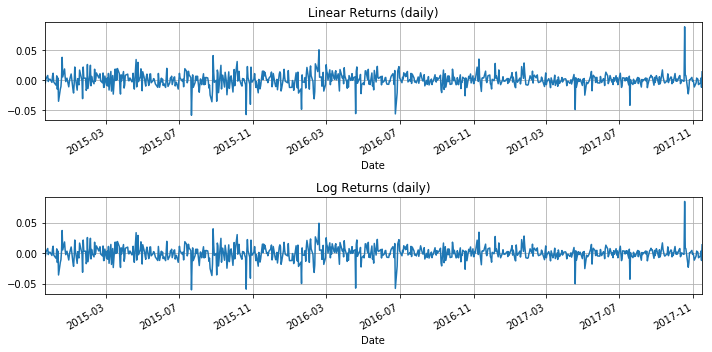

In [11]:
from scipy.stats import norm

# compute linear and log returns
rlin = (S - S.shift(1))/S.shift(1)
rlog = np.log(S/S.shift(1))

rlin = rlin.dropna()
rlog = rlog.dropna()

# plot data
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
rlin.plot()
plt.title('Linear Returns (daily)')
plt.grid()
plt.tight_layout()

plt.subplot(2,1,2)
rlog.plot()
plt.title('Log Returns (daily)')
plt.grid()
plt.tight_layout()

print('\nLinear Returns')
mu,sigma = norm.fit(rlin)
print('   mu = {0:12.8f}  (annualized = {1:.2f}%)'.format(mu,100*252*mu))
print('sigma = {0:12.8f}  (annualized = {1:.2f}%)'.format(sigma,100*np.sqrt(252)*sigma))

print('\nLog Returns')
nu,sigma = norm.fit(rlog)
print('   nu = {0:12.8f}  (annualized = {1:.2f}%)'.format(nu,100*252*nu))
print('sigma = {0:12.8f}  (annualized = {1:.2f}%)'.format(sigma,100*np.sqrt(252)*sigma))

## Binomial Model

The binomial model provides a means of modeling the statistical distribution of future prices. Given a current price $S_t$, there are two possible states for the next observed value $S_{t+\Delta t}$

$$S_{t + \Delta t} = \begin{cases} u S_t & \mbox{with probability } p \\ d S_t & \mbox{with probability } 1-p\end{cases}$$

where $u$, $d$, and $p$ are chosen to match the statistics of a model based on Geometric Brownian Motion. 
The following parameter values are derived in [Luenberger (2013)](https://global.oup.com/ushe/product/investment-science-9780199740086?cc=us&lang=en&),

\begin{align*}
p & = \frac{1}{2} + \frac{\nu\Delta t}{2\sqrt{\sigma^2\Delta t + (\nu\Delta t)^2}} \\
\ln u & = \sqrt{\sigma^2\Delta t + (\nu\Delta t)^2} \\
\ln d & = - \sqrt{\sigma^2\Delta t + (\nu\Delta t)^2} 
\end{align*}

In [118]:
# Time/period
dt = 21

p = 0.5 + nu*dt/2/np.sqrt(dt*sigma**2 + (nu*dt)**2)
u = np.exp(np.sqrt(dt*sigma**2 + (nu*dt)**2))
d = np.exp(-np.sqrt(dt*sigma**2 + (nu*dt)**2))

print('Probability (p) = ', round(p,4))
print('  Up Return (u) = ', round(u,4))
print('Down Return (d) = ', round(d,4))

Probability (p) =  0.5063
  Up Return (u) =  1.0573
Down Return (d) =  0.9458


The model extends to multiple time steps in a natural way as shown in this diagram:

![](../img/BinomialModel.png)

Note that each step forward in time introduces an additional state to the set of possible outcomes.

For the purpose of coding, we will use Python dictionaries to store future prices $S^f$. Future prices are indexed by two subscripts, $k$ and $s$, such that ``Sf[k,s]`` corresponds to the price at time $t + k\Delta t$ in state $s$.

We start by setting the initial node equal to the last observed price, $S^f_{0,0} = S_t$. For each $k$ and $s$ there are two subsequent nodes

\begin{align*}
S^f_{k + 1, s} & = u S^f_{k,s} \\
S^f_{k + 1, s + 1} & = d S^f_{k,s}
\end{align*}

These two equations can be combined by eliminating the common term $S^f_{k,s}$ to yield

\begin{align*}
S^f_{k + 1, s} & = u S^f_{k,s} \\
S^f_{k+1,s+1} & = \frac{d}{u} S^f_{k+1,s}
\end{align*}

These formula can be solved explicit to give

$$S^f_{k,s} = u^{k-s}d^{s}S^f_{0,0}$$

which is the formula used below to compute values in the binomial lattice.

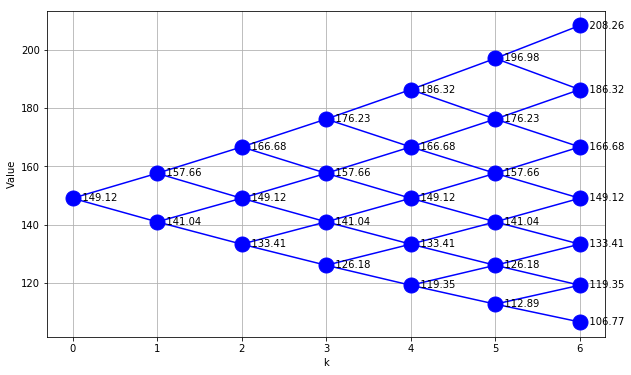

In [172]:
N = 6

# initialize Sf
Sf = {}
Sf[0,0] = S[-1]

# compute values
for k in range(1,N+1):
    for s in range(0,k+1):
        Sf[k,s] = u**(k-s)*d**s*Sf[0,0]
      
%matplotlib inline
def Sdisplay(Sf):
    plt.figure(figsize=(10,6))
    for k,s in Sf.keys():
        plt.plot(k,Sf[k,s],'.',ms=30,color='b')
        plt.text(k,Sf[k,s],'   {0:.2f}'.format(Sf[k,s]),ha='left',va='center')
        if (k > 0) & (s < k):
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s]],'b')
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s+1]],'b')
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.grid()
    
Sdisplay(Sf)

The probability of reaching state $s$ at time step $k$ is denoted by $P_{k,s}$. This can be computed given probability of preceding states and the conditional probabilities $p$ and $1-p$.

\begin{align*}
P_{k,s} & = p P_{k-1,s} + (1-p) P_{k-1,s-1}
\end{align*}

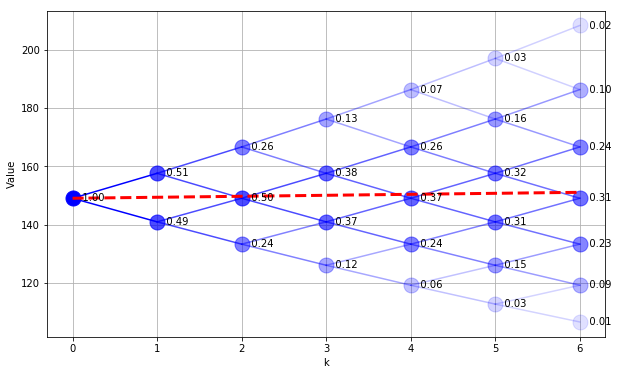

In [182]:
P = {}
P[0,0] = 1

for k in range(0,N):
    P[k+1,0] = p*P[k,0]
    P[k+1,k+1] = (1-p)*P[k,k]
    for s in range(1,k+1):
        P[k+1,s] = p*P[k,s] + (1-p)*P[k,s-1]

%matplotlib inline
def SPdisplay(Sf,P,D):
    plt.figure(figsize=(10,6))
    nPeriods = max([k for k,s in Sf.keys()]) + 1
    Sfmean = np.zeros(nPeriods)
    for k,s in Sf.keys():
        Sfmean[k] += Sf[k,s]*P[k,s]
        plt.plot(k,Sf[k,s],'.',ms=30,color='b',alpha=np.sqrt(P[k,s]))
        if (k > 0) & (s < k):
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s]],'b',alpha=np.sqrt(P[k-1,s]))
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s+1]],'b',alpha=np.sqrt(P[k-1,s]))
    for k,s in D.keys():
        plt.text(k,Sf[k,s],'   {0:.2f}'.format(D[k,s]),ha='left',va='center')
    plt.plot(range(0,nPeriods),Sfmean,'r--',lw=3)
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.grid()
SPdisplay(Sf,P,P)

## European Call Option

A European Call Option is a contract the provides the holder with the right, but not the obligation, to purchase an asset at a specified price and date in the future. The specified price is generally called the **strike price**, and the specified date is the **expiration date**. 

The purpose of the call option is to reduce the holder's exposure to the risk of increasing prices. An airline, for example, might choose to purchase call options on airplance fuels in order to reduce the risk of selling advance tickets.

The value of the call option upon expiration depends on the price of underlying asset. If the asset spot price $S$ is greater than the strike price $K$, then the call option is worth the difference $S-K$ because that is amount needed to fulfill the contract in the spot market. 

On the other hand, if the asset price falls below the strike price, then the option contract has no value since the holder could buy the asset on the spot market for less than the strike price.

$$C_{N,s} = \max(0, S^f_{N,s})$$

The next cell demonstrates the terminal value of a european call option where the strike price is equal to the initial price (known as an 'at the money' strike).

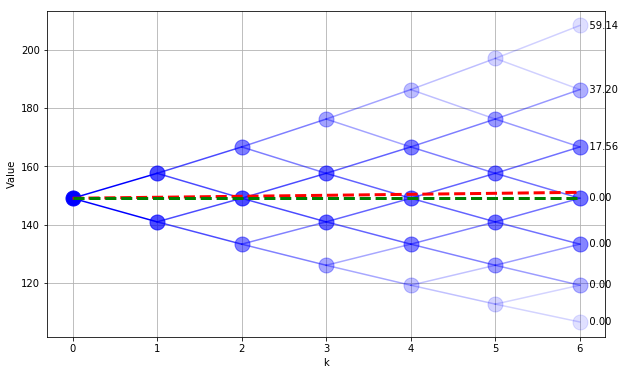

In [184]:
K = Sf[0,0]
C = {}
for s in range(0,N+1):
    C[N,s] = max(0,Sf[N,s] - K)

SPdisplay(Sf,P,C)
plt.plot([0,N],[K,K],'g--',lw=3)

To price a call option, consider the construction of a portfolio composed of the underlying asset and cash that would have the same payoff. At node $k,s$, the portfolio is given by 

$$C_{k,s} = x_{k,s}S^f_{k,s} + y_{k,s}$$

where $x_{k,s}$ is the number of units of the underlying asset, and $y_{k,s}$ is the cash component of the portfolio. The subsequent value of the portfolio at $k+1$ has two possible values

\begin{align*}
C_{k+1,s} & = x_{k,s}uS^f_{k,s} + (1+r)y_{k,s} \\
C_{k+1,s+1} & = x_{k,s}dS^f_{k,s} + (1+r)y_{k,s}
\end{align*}

where $r$ is the per period interest rate for cash. Solving for $x_{k,s}$ and $y_{k,s}$,

\begin{align*}
x_{k,s} & = \frac{C_{k+1,s} - C_{k+1,s+1}}{(u-d)S^f_{k,s}} \\
y_{k,s} & = \frac{uC_{k+1,s+1}-dC_{k+1,s}}{(1+r)(u-d)}
\end{align*}

Inserting these solutions into the original expression,

$$C_{k,s} = \frac{(\left[(1+r) - d\right]C_{k+1,s} + \left[u - (1+r)\right]C_{k+1,s+1}}{(1+r)(u-d)}$$

This can be expressed in a far more suggestive form

$$C_{k,s} = \frac{1}{1+r}\left[\underbrace{\frac{(1+r)-d}{u-d}}_{q}C_{k+1,s} + \underbrace{\frac{u-(1+r)}{u-d}}_{1-q}C_{k+1,s+1}\right]$$

or

$$C_{k,s} = \frac{1}{1+r}\left[q C_{k+1,s} + (1-q)C_{k+1,s+1}\right]$$

This expression has two important consequences. The first is an interpretation as a 'risk-neutral' probability such that C_{k,s} is the 'expected value' of the call option. This is not the real-world probability! Instead, it is different measure that provides a very useful means of computing the value of options as illustrated in the following diagram.

![](../img/BinomialModel_Options.png)


Text(0.5,1,'Cash Position')

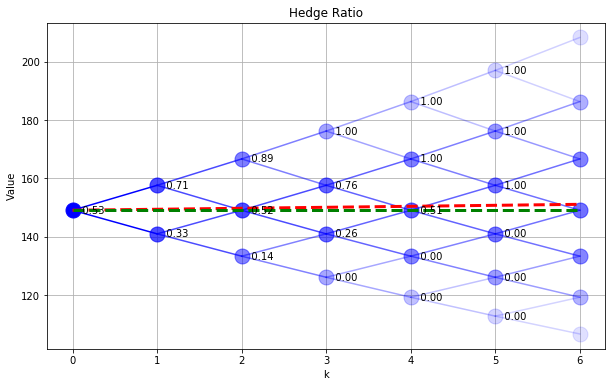

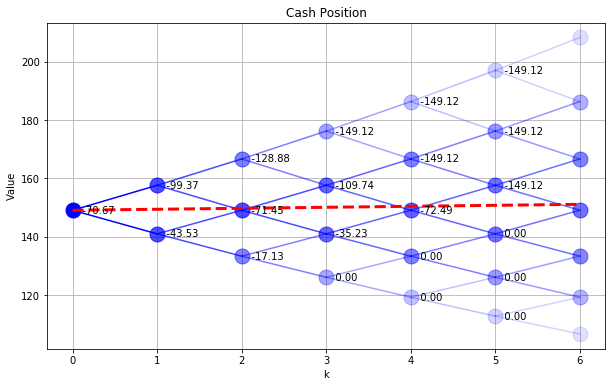

In [190]:
r = 0.0
q = (1+r-d)/(u-d)

K = Sf[0,0]
x = {}
y = {}

for k in reversed(range(0,nPeriods)):
    for s in range(0,k+1):
        x[k,s] = (C[k+1,s]-C[k+1,s+1])/(u-d)/Sf[k,s]
        y[k,s] = C[k,s] - x[k,s]*Sf[k,s]

SPdisplay(Sf,P,x)
plt.plot([0,N],[K,K],'g--',lw=3)
plt.title('Hedge Ratio')

SPdisplay(Sf,P,y)
plt.title('Cash Position')

## Pyomo Implementation


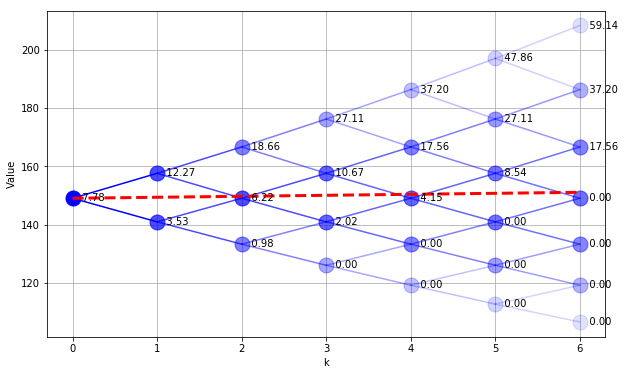

In [201]:
from pyomo.environ import *
import pandas as pd

m = ConcreteModel()

N = 6
Periods = range(0,N+1)
States = range(0,N+1)

m.C = Var(Periods,States,domain=Reals)

m.cons = ConstraintList()

for s in range(0,N+1):
    m.cons.add(m.C[N,s] == max(0,Sf[N,s]-K))

for k in range(0,N):
    for s in range(0,k+1):
        m.cons.add(m.C[k,s] == q*m.C[k+1,s] + (1-q)*m.C[k+1,s+1])

m.OBJ = Objective(expr = m.C[0,0], sense=minimize)
SolverFactory('glpk').solve(m)
    
C = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        C[k,s] = m.C[k,s]()

SPdisplay(Sf,P,C)

## Replicating Portfolio

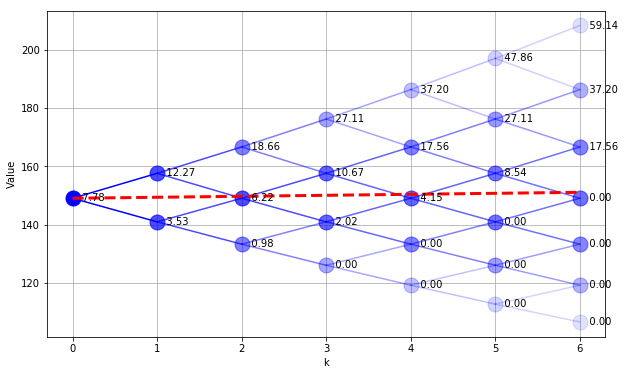

In [208]:
from pyomo.environ import *
import pandas as pd

m = ConcreteModel()

N = 6
Periods = range(0,N+1)
States = range(0,N+1)

# future bond prices
B = {}
for k in Periods:
    B[k] = (1+r)**k

m.C = Var(Periods,Periods,domain=Reals)
m.x = Var(Periods,Periods,domain=Reals)
m.y = Var(Periods,Periods,domain=Reals)

m.cons = ConstraintList()

for k in range(0,N+1):
    for s in range(0,k+1):
        m.cons.add(m.C[k,s] == m.x[k,s]*Sf[k,s] + m.y[k,s]*B[k])

for s in range(0,N+1):
    m.cons.add(m.C[N,s] >= max(0,Sf[N,s] - K))

for k in range(0,N):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*Sf[k+1,s] + m.y[k,s]*B[k+1] >= m.C[k+1,s])
        m.cons.add(m.x[k,s]*Sf[k+1,s+1] + m.y[k,s]*B[k+1] >= m.C[k+1,s+1])

m.OBJ = Objective(expr = m.C[0,0], sense=minimize)
SolverFactory('glpk').solve(m)

C = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        C[k,s] = m.C[k,s]()
        
SPdisplay(Sf,P,C)

## American Put Option

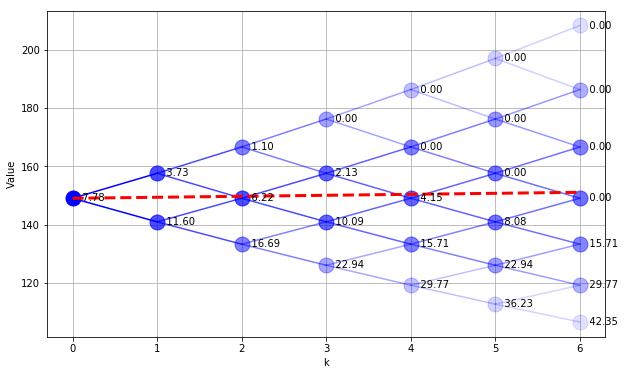

In [215]:
from pyomo.environ import *
import pandas as pd

m = ConcreteModel()

N = 6
Periods = range(0,N+1)
States = range(0,N+1)

# future bond prices
B = {}
for k in Periods:
    B[k] = (1+r)**k

m.P = Var(Periods,Periods,domain=Reals)
m.x = Var(Periods,Periods,domain=Reals)
m.y = Var(Periods,Periods,domain=Reals)

m.cons = ConstraintList()

for k in range(0,N+1):
    for s in range(0,k+1):
        m.cons.add(m.P[k,s] == m.x[k,s]*Sf[k,s] + m.y[k,s]*B[k])

for s in range(0,N+1):
    m.cons.add(m.P[nPeriods,s] >= max(0,K - Sf[nPeriods,s]))

for k in range(0,N):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*Sf[k+1,s] + m.y[k,s]*B[k+1] >= m.P[k+1,s])
        m.cons.add(m.x[k,s]*Sf[k+1,s+1] + m.y[k,s]*B[k+1] >= m.P[k+1,s+1])

# early exercise
for k in range(0,N):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*Sf[k+1,s] + m.y[k,s]*B[k+1] >= K - Sf[k+1,s])
        m.cons.add(m.x[k,s]*Sf[k+1,s+1] + m.y[k,s]*B[k+1] >= K - Sf[k+1,s+1])

m.OBJ = Objective(expr = m.P[0,0], sense=minimize)
SolverFactory('glpk').solve(m)

Put = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        Put[k,s] = m.P[k,s]()
        
SPdisplay(Sf,P,Put)